In [1]:
import cv2
import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np
# import albumentations as albu
from pathlib import Path
# from albumentations.pytorch.transforms import ToTensorV2
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
class DatasetGenerate(Dataset):
    def __init__(self, img_folder, gt_folder, phase: str = 'train', transform=None, seed=None):
        self.images = sorted(glob.glob(img_folder + '/*'))
        self.gts = sorted(glob.glob(gt_folder + '/*'))
        self.transform = transform
        train_images, val_images, train_gts, val_gts = train_test_split(self.images, self.gts,
                                                                        test_size=0.05,
                                                                        random_state=seed)
        if phase == 'train':
            self.images = train_images
            self.gts = train_gts
        elif phase == 'val':
            self.images = val_images
            self.gts = val_gts
        else:
            pass

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.transform[1] == 1:
            image = torchvision.io.read_image(self.images[idx], torchvision.io.image.ImageReadMode(3)) / 255.0
            mask = torchvision.io.read_image(self.gts[idx], torchvision.io.image.ImageReadMode(3)) / 255.0
            
            image = self.transform[0](image)
            mask = self.transform[0](mask)
            
        if self.transform[1] != 1:
            image = cv2.imread(self.images[idx], 1)[:, :, ::-1] / 255.0
            mask = cv2.imread(self.gts[idx], 0) / 255.0
            plt.imshow(image)
            plt.show()
    #         print(image.shape, mask.shape)
            smooth_y = np.multiply(cv2.blur(image, (9, 9)), 1-np.repeat(mask[:,:,np.newaxis], 3, axis=2))
            ground_y = np.multiply(image, np.repeat(mask[:,:,np.newaxis], 3, axis=2))
            mask = smooth_y + ground_y

            image = torch.from_numpy(image.transpose((2, 0, 1)))
            mask = torch.from_numpy(mask.transpose((2, 0, 1)))
            
            image = self.transform[0](image)
            mask = self.transform[0](mask)
        return image, mask

    def __len__(self):
        return len(self.images)

class Test_DatasetGenerate(Dataset):
    def __init__(self, img_folder, gt_folder=None, transform=None):
        self.images = sorted(glob.glob(img_folder + '/*'))
        self.gts = sorted(glob.glob(gt_folder + '/*')) if gt_folder is not None else None
        self.transform = transform

    def __getitem__(self, idx):
        image_name = Path(self.images[idx]).stem
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image.shape[:2]

        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.gts is not None:
            return image, self.gts[idx], original_size, image_name
        else:
            return image, original_size, image_name

    def __len__(self):
        return len(self.images)


def get_loader(img_folder, gt_folder, phase: str, batch_size, shuffle, 
               num_workers, transform=None, seed=None):
    if phase == 'test':
        dataset = Test_DatasetGenerate(img_folder, gt_folder, transform)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    else:
        dataset = DatasetGenerate(img_folder, gt_folder, phase, transform, seed)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
                                 drop_last=True)

    print(f'{phase} length : {len(dataset)}')
    return data_loader

class fourier_coefficient(object):
#     def __init__(self) -> None:
#         _log_api_usage_once(self)

    def __call__(self, img):
        fourier = torch.zeros(img.shape)
#         (c, h, w) = img.shape
#         print(img.shape, fourier.shape)

        for i in range(3):
            fourier[i, :, :] = torch.fft.fft2(img[i, :, :])
        return fourier
    
class fourier_amplitude(object):
    def __call__(self, img):
        fourier = torch.zeros(img.shape)
        for i in range(3):
            fourier[i, :, :] = torch.absolute(torch.fft.fftshift(torch.fft.fft2(img[i, :, :])))
        return fourier

class fourier_phase(object):
    def __call__(self, img):
        fourier = torch.zeros(img.shape)
        for i in range(3):
            fourier[i, :, :] = torch.angle(torch.fft.fftshift(torch.fft.fft2(img[i, :, :])))
        return fourier
    
def get_train_augmentation(img_size, ver):
    '''
    ver1: 純看原圖, 黑白mask
    ver2: 看原圖的 傅立葉係數, 背景虛化後的 傅立葉係數
    ver3: 看原圖的 amplitude, 背景虛化後的 amplitude
    ver4: 看原圖的 phase, 背景虛化後的 phase
    '''
    if ver == 1: 
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((img_size, img_size)),
        ])
    if ver == 2:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((img_size, img_size)),
            fourier_coefficient()
        ])
    if ver == 3:
        transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((img_size, img_size)),
        fourier_amplitude()
    ])
    if ver == 4:
        transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((img_size, img_size)),
        fourier_phase()
    ])
        
    return [transform, ver]

def get_test_augmentation(img_size):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((img_size, img_size)),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
    ])
    return transform

train length : 10025
val length : 528


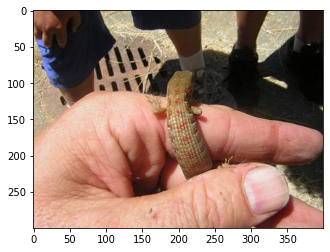

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


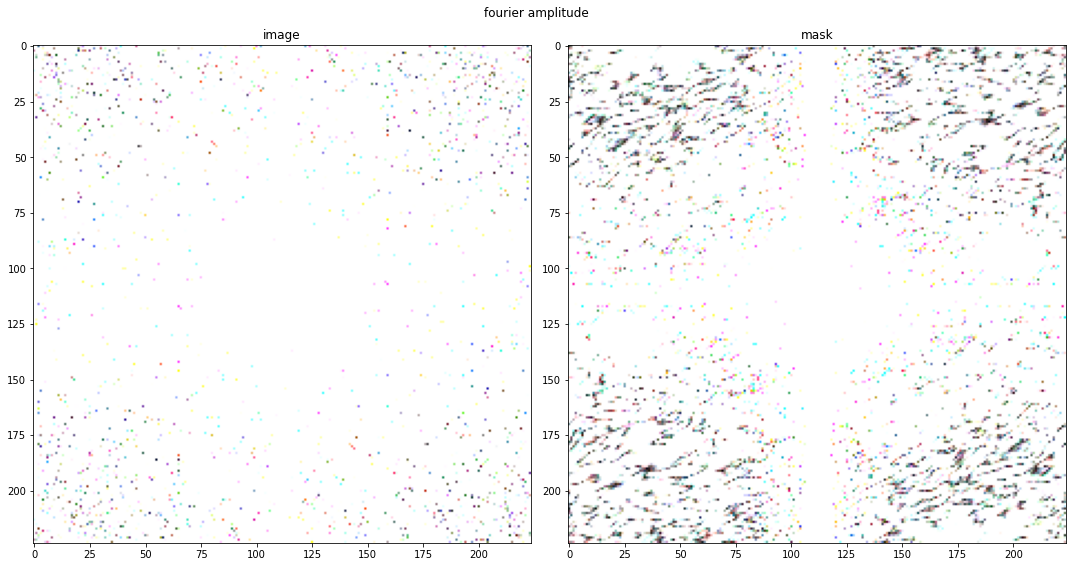

In [3]:
if __name__ == '__main__':
    tr_img_folder = os.path.join(r'C:\Users\user\mission87\data\DUTS\DUTS-TR\DUTS-TR-Image')
    tr_gt_folder = os.path.join(r'C:\Users\user\mission87\data\DUTS\DUTS-TR\DUTS-TR-Mask')
    tr_edge_folder = os.path.join(r'C:\Users\user\mission87\data\DUTS\DUTS-TR\edges')
    
    ver = 3
    train_transform = get_train_augmentation(img_size=224, ver=ver)
    test_transform = get_test_augmentation(img_size=224)

    train_loader = get_loader(tr_img_folder, tr_gt_folder, phase='train',
                              batch_size=1, shuffle=True, num_workers=0,
                              transform=train_transform)
    val_loader = get_loader(tr_img_folder, tr_gt_folder, phase='val',
                            batch_size=1, shuffle=False, num_workers=0,
                            transform=train_transform)
    
    s = {1: 'Nothing change', 2: 'Fourier coefficients', 3: 'Fourier amplitude', 4: 'Fourier phase'}
    
    image, mask = next(iter(train_loader))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    fig.suptitle(s[ver], verticalalignment='bottom')
    ax1.imshow(image[0].permute(1, 2, 0))
    ax1.set_title('image')
    ax2.imshow(mask[0].permute(1, 2, 0), 'gray')
    ax2.set_title('mask')
    fig.tight_layout()
    fig.subplots_adjust(top=0.99)
    plt.show()